In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
from utils import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

matplotlib.rc('figure', figsize=(10, 5))

%matplotlib inline

In [2]:
df = pd.read_csv('chembl.csv')

In [3]:
df = df[~pd.isnull(df.acd_logd) & ~pd.isnull(df.acd_logp)]

In [4]:
df['affinity'] = np.zeros(df.shape[0])

In [5]:
rnn_cell_size = 64
num_layers = 1
embedding_size = 32

split_size = 30
batchsize = 100
epochs = 20
stride=1

num_features = 3

In [6]:
class CharRNN:
    def __init__(self, sess, input_dim, output_dim, embedding_size, rnn_cell_size, num_layers, end_elem, sess_chkpt=''):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rnn_cell_size = rnn_cell_size
        self.num_layers = num_layers
        self.state_shape =  num_layers*2*rnn_cell_size
        self.end_elem = end_elem
        
        # Main architecrure
        
        self.X = tf.placeholder(tf.float64, shape=[None, None, input_dim])
        
        self.state = tf.placeholder(tf.float64, shape=[None, self.state_shape])
        
        self.lengths = tf.placeholder(tf.float64, shape=[None])
        
        # Embedding
        n_steps = tf.shape(self.X)[1]
        
        flat_X = tf.reshape(self.X, [-1, input_dim])
        
        embedding_matrix = tf.get_variable('Embedding_Matrix', shape=[input_dim, embedding_size], 
                                               initializer=xavier_initializer(), dtype=tf.float64)
        
        embedded = tf.reshape(tf.nn.relu(tf.matmul(flat_X, embedding_matrix)), [-1, n_steps, embedding_size])
        
        # RNN
        rnn_cells = [tf.contrib.rnn.LSTMCell(rnn_cell_size, state_is_tuple=False, initializer=xavier_initializer()) 
                                 for i in range(num_layers)]

        multiple_cells = tf.contrib.rnn.MultiRNNCell(rnn_cells, state_is_tuple=False)

        rnn_output, self.new_state = tf.nn.dynamic_rnn(multiple_cells, embedded, initial_state=self.state, 
                                                       dtype=tf.float64, sequence_length=self.lengths)
        
        # First dense
        
        f_d = tf.layers.dense(rnn_output[:, -1], rnn_cell_size//2, activation=tf.nn.relu, kernel_initializer=xavier_initializer())
        
        # Output
        
        output_logits = tf.layers.dense(f_d, output_dim, kernel_initializer=xavier_initializer())

        self.output = tf.nn.softmax(output_logits)
        
        # Training utils
        
        self.Y = tf.placeholder(tf.float64, shape=[None, output_dim])

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits, labels=self.Y))
        
        # Optimizer 
        
        self.optim = tf.train.AdamOptimizer().minimize(self.loss)
        
        # Saver
        
        self.saver = tf.train.Saver()
        
        # Stuff
        
        self.sess = sess
        
        if len(sess_chkpt):
            self.saver.restore(self.sess, sess_chkpt)
        else:
            self.sess.run(tf.global_variables_initializer())

    def train_step(self, X, Y, lengths):
        
        initial_states = np.zeros([len(X), self.state_shape])
        
        feed_dict = {
            self.X: X,
            self.Y: Y,
            self.state: initial_states,
            self.lengths: lengths
        }
        
        _, loss = self.sess.run([self.optim, self.loss], feed_dict=feed_dict)
        
        return loss
    
    def generate_element(self, x, zero_state=True):
        
        if zero_state:
            state = np.zeros([1, self.state_shape])
        else:
            state = self.previous_state
        
        feed_dict = {
            self.X: [x],
            self.state: state,
            self.lengths: [len(x)]
        }
        
        next_element, new_state = self.sess.run([self.output, self.new_state], feed_dict=feed_dict)
        
        self.previous_state = new_state
        
        return next_element
    
    def generate_sequence(self, start, max_len=np.inf):
        
        num_features = self.input_dim - self.output_dim
        
        features = start[0][:num_features]
        
        sequence = [np.argmax(x[num_features:]) for x in start]

        next_element = np.argmax(self.generate_element(start, zero_state=True))

        while next_element != self.end_elem and len(sequence) < max_len:
        
            sequence.append(next_element)
            
            next_input = np.concatenate([features, to_categorical(next_element, self.output_dim)[0]])
            
            next_element = np.argmax(self.generate_element([next_input], False))
            
        return sequence
    
    def save(self, path):
        self.saver.save(self.sess, path)

In [7]:
sess = tf.Session()

In [8]:
model = CharRNN(sess, len(elems)+num_features, len(elems), embedding_size, rnn_cell_size, num_layers, len(elems)-1)

In [9]:
features = df[["acd_logd", "acd_logp", "affinity"]].values

In [10]:
X_data, Y_data = get_train(df.canonical_smiles.values, features, split_size, stride)

In [36]:
freqs = df.canonical_smiles.apply(lambda x: x[0]).value_counts() / df.shape[0]

possible_start = freqs.index.values
freqs = freqs.values

In [37]:
def choose_start(possible, probs):
    return np.random.choice(possible)

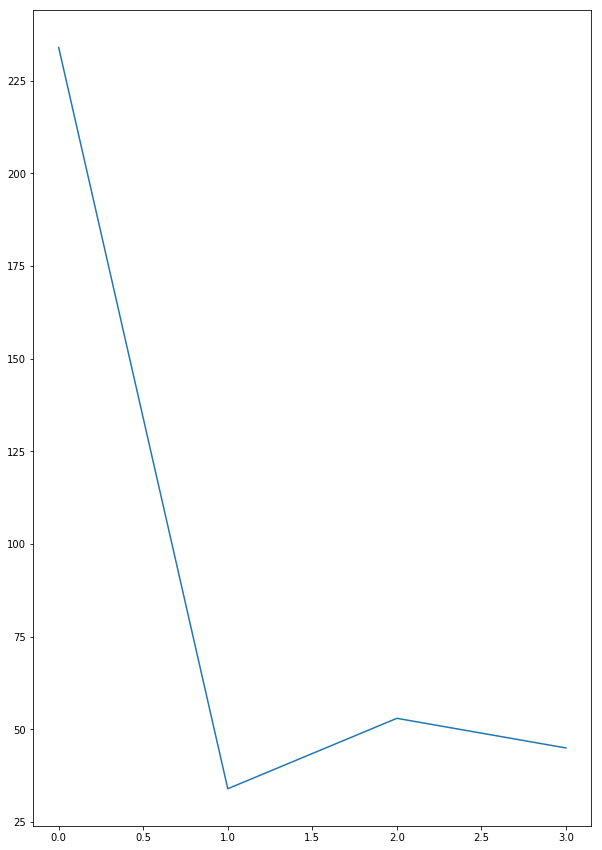

In [26]:
plt.figure(figsize=[10, 15])
plt.plot([234,34,53,45])

In [72]:
for epoch in range(epochs):
    losses = []
    
    print("Epoch number: ", epoch)
    
    for X_batch, Y_batch in tqdm_notebook(iterate_minibatches(X_data, Y_data, batchsize, True), 
                                             total=len(X_data)//batchsize):
        
        lengths = list(map(lambda x: len(x)-num_features, X_batch))
        
        X_batch = make_trainable(X_batch, num_features)
        
        loss = model.train_step(X_batch, Y_batch, lengths)
        losses.append(loss)
        
        if len(losses) % 100 == 0:
            
        
        if len(losses) % 20 == 0:
            start = choose_start(possible_start, freqs)
            
            feat = features[np.random.choice(np.arange(0, features.shape[0]))]
            
            print("Sample: ", to_smile(model.generate_sequence([np.concatenate([feat, to_one_hot(start, False)[0]])], 100)))
            
            model.save('tmp/{}_{}.chkpt'.format(epoch, len(losses)))
            
    print("Epoch loss: ", np.mean(losses))
    

Epoch number:  0


1.02722392242
0.922915384485
Sample:  [
1.12764356814

1.18018348717
Sample:  Br
0.88266467166
0.738123089358
Sample:  c3
1.1018422894
1.06627507377
Sample:  c3
0.962703016206
1.01984772495
Sample:  S
0.819380410913
0.852297639827
Sample:  S
1.04151994228
1.13094925772
Sample:  C
0.919205402739
1.18404385844
Sample:  N
0.950993456026
0.937083246301
Sample:  c3
0.929899980581
1.32628429877
Sample:  [
0.961734336738
1.12886733893
Sample:  F
0.9818225143
0.905980376449
Sample:  F
1.06836796338
0.995614040251
Sample:  C
0.994995896035
0.99025561668
Sample:  c3)(C)C
0.997559357363
1.16129101294
Sample:  N
0.908812697491
1.03085457311
Sample:  I
0.82736384152
1.17208908
Sample:  [
1.07283105969
0.98121456644
Sample:  S
0.863134672606
1.0521381416
Sample:  S
0.873637458961
1.09740094248
Sample:  C
0.886702406837
1.03158026113
Sample:  oc3
0.972728564029
1.05053325483
Sample:  I
0.961095204648
0.977765940057
Sample:  C
0.987438421665
0.805866248109
Sample:  S
0.865276419774
1.00196195281
Sampl

0.877427012995
Sample:  F
0.776116628636
1.02554953732
Sample:  Br
1.08409227587
0.94944275164
Sample:  I
1.03405455748
0.930777015731
Sample:  oc3
1.03596672199
0.91631513228
Sample:  [
1.05465752795
1.07575248413
Sample:  S
0.962956188488
1.00838654063
Sample:  I
1.05472953689
0.630142716831
Sample:  C
1.04887868143
0.803070734541
Sample:  oc3
0.715775864643
0.742337017178
Sample:  N
1.08670354812
0.980060246386
Sample:  oc3
0.904115844851
0.885979775919
Sample:  S
1.10693029492
0.971499507524
Sample:  S
1.01310865665
1.00143540763
Sample:  N
0.887280709284
0.886553757782
Sample:  C
0.966353375241
0.932018005015
Sample:  I
1.10961612148
1.0180178178
Sample:  S
0.750804031559
0.902207977634
Sample:  [
0.825661990279
0.883309098491
Sample:  S
0.944209745675
0.87626658518
Sample:  S
0.838011612092
0.828490002186
Sample:  O
0.917395797716
1.08207527453
Sample:  Br
0.954067741513
0.821104151387
Sample:  S
0.757462394425
1.0521356238
Sample:  C
1.10766492954
1.0036460401
Sample:  oc3
0.856

1.00828854976
Sample:  F
0.810954813364
0.774132328601
Sample:  C
0.875658951137
0.765173139577
Sample:  I
1.00686363453
0.704528902633
Sample:  O
1.06984901347
0.832349554188
Sample:  N
1.00826301481
0.96656174271
Sample:  c3ccccc23
0.902077964877
0.883715258059
Sample:  c3ccccc23
0.837922986909
0.992596723322
Sample:  O
0.834039678998
0.854937888485
Sample:  c3ccccc23
0.931835840858
0.968422511089
Sample:  I
1.05934497733
1.03262392359
Sample:  O
1.03296890353
0.89129155201
Sample:  I
1.01791784043
0.668072471526
Sample:  O
1.08556401264
0.885760024083
Sample:  I
0.821792559452
1.19017034826
Sample:  Br
0.845368857889
0.833265419459
Sample:  c3cccc12
0.829385838627
0.764584292781
Sample:  C
0.900449171312
1.05480169147
Sample:  S
0.836379772798
0.901204967868
Sample:  N
0.819380507923
0.830529278655
Sample:  c3ccccc23
0.976746153696
1.10006512751
Sample:  S
0.917432925391
0.861606114175
Sample:  c3ccccc22
1.09915614767
0.973755400174
Sample:  I
0.813124849353
0.653797691858
Sample:  

0.743176831774
0.979912175687
Sample:  B
1.09888761525
0.814148447808
Sample:  S
0.75684079236
1.02922421521
Sample:  B
0.838099210452
0.90688884144
Sample:  []
0.714163891793
1.09030372568
Sample:  C
0.92062663714
0.833759913913
Sample:  c3ccccc23
1.01504998844
1.04268853321
Sample:  N(=O)(O)O
1.23417564899
0.988463171199
Sample:  oc3
0.651726056653
0.879133590405
Sample:  I
0.825161553856
0.892431951215
Sample:  o3
1.07457220609
0.945740476374
Sample:  S
0.868723415683
1.07749579376
Sample:  C
0.950518853442
0.855495992821
Sample:  S
0.848758657127
0.958213850131
Sample:  F
0.890983399701
1.03706503358
Sample:  N
0.866580238901
0.820083900263
Sample:  o3
0.887573329902
0.680938960388
Sample:  N(=O)(O)O
0.840696734569
0.776096012336
Sample:  N
0.75804798564
0.844391819016
Sample:  []
0.782227423467
0.890361058582
Sample:  F
0.825017306319
0.820168980359
Sample:  o(
0.82448587126
0.914625964838
Sample:  I
0.994828774107
0.840349351638
Sample:  []
0.675685488738
1.05677965502
Sample:  o

0.764271820896
Sample:  o3
0.796318668565
0.92894637361
Sample:  []]]2)(C)(C)C
0.689571884725
0.740690091357
Sample:  S
0.928037081344
0.920545093648
Sample:  o3
0.909755243532
0.908510458619
Sample:  I
1.07136814747
0.842613481385
Sample:  O
0.820166905047
0.877423902325
Sample:  O
0.853104023094
0.827075822609
Sample:  c3cccc12
0.751397107463
0.952057911051
Sample:  O
0.803512526237
0.914217963928
Sample:  oc3
0.919129883982
0.658170765306
Sample:  []]]2)(C)(C)C
1.03073355966
0.93093603782
Sample:  []]]2)(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
0.789252159934
0.779075632269
Sample:  B
0.904594423499
0.925749768251
Sample:  []
0.872203988712
0.921674598468
Sample:  F
0.723728110826
0.917904530074
Sample:  []
0.805129502844
0.866089891814
Sample:  C
0.726105530039
0.976298149108
Sample:  F
0.901580960617
0.608320765775
Sample:  F
0.880237681448
0.910660087892
Sample:  N
1.08612637101
0.731567755251
Sample:  S
0.665612616232
1.05796384816
Sample:  c3cccc12
0.89057

KeyboardInterrupt: 